# EVA 5 - Session 6

## 1. With L1 + BN: 

## 2. With L2 + BN: 

## 3. With L1 and L2 with BN: 

## 4. With GBN: 

## 5. With L1 and L2 with GBN: 

3. Results: 
    1. Parameters: 9,608
    2. Best Training Accuracy: 99.25%
    3. Best Test Accuracy: 99.48%

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
g_dataloader_args = dict(shuffle=True, batch_size=256, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=256)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
g_train_loader = torch.utils.data.DataLoader(train, **g_dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)
g_test_loader = torch.utils.data.DataLoader(test, **g_dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

# The model
Let's start with the model we first saw

In [5]:
import torch.nn.functional as F
dropout_value = 0.01
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) 

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) 

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        )

        self.pool1 = nn.MaxPool2d(2, 2) 

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) 

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) 
        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) 

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) 

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) 

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) 

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)
        x = self.convblock9(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
              ReLU-6            [-1, 8, 24, 24]               0
       BatchNorm2d-7            [-1, 8, 24, 24]              16
           Dropout-8            [-1, 8, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           1,152
             ReLU-10           [-1, 16, 22, 22]               0
      BatchNorm2d-11           [-1, 16, 22, 22]              32
          Dropout-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

total_test_losses = {}
total_test_acc = {}

def train(model, device, train_loader, optimizer, epoch, iter):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    # Calculating L1 Loss.
    if(iter == 1 or iter == 3 or iter == 5):
      lambda_l1 = 0.001
      l1 = 0
      for p in model.parameters():
        l1 = l1 + p.abs().sum()
      loss = loss + lambda_l1 * l1
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, iter):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    if iter not in total_test_losses:
      total_test_losses[iter] = []
    total_test_losses[iter].append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    if iter not in total_test_acc:
      total_test_acc[iter] = []
    total_test_acc[iter].append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [8]:
from torch.optim.lr_scheduler import StepLR

models = {}

for iter in range(1, 6): 
  # L2 Loss
  if(iter == 2 or iter == 3 or iter == 5):
    wd_val = 0.01
  else:
    wd_val = 0

  if(iter == 4 or iter == 5):
    learn_r = 1e-2
    wd_val = 5e-4

  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=wd_val)
  scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

  EPOCHS = 25
  if(iter == 1):
    print("\n\nL1 + BN", end="\n\n")
  elif(iter == 2):
    print("L2 + BN", end="\n\n")
  elif(iter == 3):
    print("L1 and L2 with BN", end="\n\n")
  elif(iter == 4):
    print("GBN", end="\n\n")
  else:
    print("L1 and L2 with GBN", end="\n\n")
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      if(iter == 4 or iter == 5):
        train(model, device, g_train_loader, optimizer, epoch, iter)
        test(model, device, g_test_loader, iter)
      else:
        train(model, device, train_loader, optimizer, epoch, iter)
        test(model, device, test_loader, iter)

  models[iter] = model

  0%|          | 0/938 [00:00<?, ?it/s]



L1 + BN

EPOCH: 0


Loss=0.6316194534301758 Batch_id=937 Accuracy=92.03: 100%|██████████| 938/938 [00:32<00:00, 28.51it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0901, Accuracy: 9729/10000 (97.29%)

EPOCH: 1


Loss=0.4219062328338623 Batch_id=937 Accuracy=96.92: 100%|██████████| 938/938 [00:33<00:00, 28.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0867, Accuracy: 9739/10000 (97.39%)

EPOCH: 2


Loss=0.739142119884491 Batch_id=937 Accuracy=97.05: 100%|██████████| 938/938 [00:33<00:00, 28.21it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0651, Accuracy: 9805/10000 (98.05%)

EPOCH: 3


Loss=0.45081663131713867 Batch_id=937 Accuracy=97.26: 100%|██████████| 938/938 [00:33<00:00, 28.18it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0625, Accuracy: 9820/10000 (98.20%)

EPOCH: 4


Loss=0.5233557224273682 Batch_id=937 Accuracy=97.27: 100%|██████████| 938/938 [00:33<00:00, 28.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0809, Accuracy: 9741/10000 (97.41%)

EPOCH: 5


Loss=0.30040398240089417 Batch_id=937 Accuracy=97.26: 100%|██████████| 938/938 [00:33<00:00, 28.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0744, Accuracy: 9768/10000 (97.68%)

EPOCH: 6


Loss=0.2741861343383789 Batch_id=937 Accuracy=97.28: 100%|██████████| 938/938 [00:33<00:00, 28.12it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0551, Accuracy: 9826/10000 (98.26%)

EPOCH: 7


Loss=0.4169005751609802 Batch_id=937 Accuracy=97.36: 100%|██████████| 938/938 [00:33<00:00, 28.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0644, Accuracy: 9808/10000 (98.08%)

EPOCH: 8


Loss=0.31516748666763306 Batch_id=937 Accuracy=97.24: 100%|██████████| 938/938 [00:33<00:00, 28.26it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0606, Accuracy: 9825/10000 (98.25%)

EPOCH: 9


Loss=0.2822938859462738 Batch_id=937 Accuracy=97.28: 100%|██████████| 938/938 [00:33<00:00, 28.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0685, Accuracy: 9807/10000 (98.07%)

EPOCH: 10


Loss=0.29902857542037964 Batch_id=937 Accuracy=97.25: 100%|██████████| 938/938 [00:33<00:00, 28.17it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0611, Accuracy: 9813/10000 (98.13%)

EPOCH: 11


Loss=0.4110047221183777 Batch_id=937 Accuracy=97.30: 100%|██████████| 938/938 [00:33<00:00, 28.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1296, Accuracy: 9573/10000 (95.73%)

EPOCH: 12


Loss=0.34764596819877625 Batch_id=937 Accuracy=97.31: 100%|██████████| 938/938 [00:32<00:00, 28.67it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0612, Accuracy: 9825/10000 (98.25%)

EPOCH: 13


Loss=0.4597172141075134 Batch_id=937 Accuracy=97.35: 100%|██████████| 938/938 [00:32<00:00, 28.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0664, Accuracy: 9796/10000 (97.96%)

EPOCH: 14


Loss=0.4693566560745239 Batch_id=937 Accuracy=97.39: 100%|██████████| 938/938 [00:32<00:00, 28.89it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0954, Accuracy: 9710/10000 (97.10%)

EPOCH: 15


Loss=0.29735100269317627 Batch_id=937 Accuracy=97.44: 100%|██████████| 938/938 [00:32<00:00, 28.82it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1242, Accuracy: 9619/10000 (96.19%)

EPOCH: 16


Loss=0.24544097483158112 Batch_id=937 Accuracy=97.23: 100%|██████████| 938/938 [00:32<00:00, 29.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0965, Accuracy: 9703/10000 (97.03%)

EPOCH: 17


Loss=0.41888564825057983 Batch_id=937 Accuracy=97.33: 100%|██████████| 938/938 [00:32<00:00, 28.98it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0663, Accuracy: 9795/10000 (97.95%)

EPOCH: 18


Loss=0.2928720712661743 Batch_id=937 Accuracy=97.20: 100%|██████████| 938/938 [00:32<00:00, 28.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0722, Accuracy: 9779/10000 (97.79%)

EPOCH: 19


Loss=0.32838737964630127 Batch_id=937 Accuracy=97.44: 100%|██████████| 938/938 [00:32<00:00, 28.73it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0703, Accuracy: 9793/10000 (97.93%)

EPOCH: 20


Loss=0.2615610659122467 Batch_id=937 Accuracy=97.24: 100%|██████████| 938/938 [00:32<00:00, 28.67it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0641, Accuracy: 9809/10000 (98.09%)

EPOCH: 21


Loss=0.2847348153591156 Batch_id=937 Accuracy=97.32: 100%|██████████| 938/938 [00:32<00:00, 28.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0639, Accuracy: 9806/10000 (98.06%)

EPOCH: 22


Loss=0.35783445835113525 Batch_id=937 Accuracy=97.23: 100%|██████████| 938/938 [00:32<00:00, 28.82it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0727, Accuracy: 9797/10000 (97.97%)

EPOCH: 23


Loss=0.38984358310699463 Batch_id=937 Accuracy=97.31: 100%|██████████| 938/938 [00:32<00:00, 28.74it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0698, Accuracy: 9798/10000 (97.98%)

EPOCH: 24


Loss=0.25287631154060364 Batch_id=937 Accuracy=97.33: 100%|██████████| 938/938 [00:32<00:00, 28.81it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0722, Accuracy: 9790/10000 (97.90%)

L2 + BN

EPOCH: 0


Loss=0.08781930059194565 Batch_id=937 Accuracy=93.05: 100%|██████████| 938/938 [00:28<00:00, 32.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1009, Accuracy: 9819/10000 (98.19%)

EPOCH: 1


Loss=0.08732930570840836 Batch_id=937 Accuracy=97.53: 100%|██████████| 938/938 [00:28<00:00, 32.70it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0836, Accuracy: 9840/10000 (98.40%)

EPOCH: 2


Loss=0.11011189967393875 Batch_id=937 Accuracy=97.68: 100%|██████████| 938/938 [00:28<00:00, 32.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1246, Accuracy: 9751/10000 (97.51%)

EPOCH: 3


Loss=0.08697257190942764 Batch_id=937 Accuracy=97.66: 100%|██████████| 938/938 [00:28<00:00, 32.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1041, Accuracy: 9761/10000 (97.61%)

EPOCH: 4


Loss=0.16238664090633392 Batch_id=937 Accuracy=97.70: 100%|██████████| 938/938 [00:28<00:00, 32.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0796, Accuracy: 9876/10000 (98.76%)

EPOCH: 5


Loss=0.09643832594156265 Batch_id=937 Accuracy=97.77: 100%|██████████| 938/938 [00:28<00:00, 32.79it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1052, Accuracy: 9805/10000 (98.05%)

EPOCH: 6


Loss=0.0888558030128479 Batch_id=937 Accuracy=97.83: 100%|██████████| 938/938 [00:28<00:00, 32.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1066, Accuracy: 9786/10000 (97.86%)

EPOCH: 7


Loss=0.04571329802274704 Batch_id=937 Accuracy=97.77: 100%|██████████| 938/938 [00:28<00:00, 32.89it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0904, Accuracy: 9835/10000 (98.35%)

EPOCH: 8


Loss=0.20336169004440308 Batch_id=937 Accuracy=97.78: 100%|██████████| 938/938 [00:29<00:00, 32.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1178, Accuracy: 9790/10000 (97.90%)

EPOCH: 9


Loss=0.16562286019325256 Batch_id=937 Accuracy=97.85: 100%|██████████| 938/938 [00:28<00:00, 32.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0814, Accuracy: 9844/10000 (98.44%)

EPOCH: 10


Loss=0.09479837864637375 Batch_id=937 Accuracy=97.72: 100%|██████████| 938/938 [00:28<00:00, 32.74it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0905, Accuracy: 9844/10000 (98.44%)

EPOCH: 11


Loss=0.11939205229282379 Batch_id=937 Accuracy=97.86: 100%|██████████| 938/938 [00:28<00:00, 32.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0804, Accuracy: 9862/10000 (98.62%)

EPOCH: 12


Loss=0.12765248119831085 Batch_id=937 Accuracy=97.80: 100%|██████████| 938/938 [00:28<00:00, 32.79it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0806, Accuracy: 9879/10000 (98.79%)

EPOCH: 13


Loss=0.2925838828086853 Batch_id=937 Accuracy=97.79: 100%|██████████| 938/938 [00:28<00:00, 32.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1377, Accuracy: 9739/10000 (97.39%)

EPOCH: 14


Loss=0.09833770990371704 Batch_id=937 Accuracy=97.87: 100%|██████████| 938/938 [00:28<00:00, 32.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0732, Accuracy: 9872/10000 (98.72%)

EPOCH: 15


Loss=0.1077127754688263 Batch_id=937 Accuracy=97.87: 100%|██████████| 938/938 [00:28<00:00, 32.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1213, Accuracy: 9768/10000 (97.68%)

EPOCH: 16


Loss=0.07421562075614929 Batch_id=937 Accuracy=97.83: 100%|██████████| 938/938 [00:28<00:00, 33.06it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1191, Accuracy: 9742/10000 (97.42%)

EPOCH: 17


Loss=0.2203230857849121 Batch_id=937 Accuracy=97.83: 100%|██████████| 938/938 [00:28<00:00, 32.70it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1505, Accuracy: 9727/10000 (97.27%)

EPOCH: 18


Loss=0.11876122653484344 Batch_id=937 Accuracy=97.70: 100%|██████████| 938/938 [00:28<00:00, 32.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1378, Accuracy: 9713/10000 (97.13%)

EPOCH: 19


Loss=0.15350912511348724 Batch_id=937 Accuracy=97.64: 100%|██████████| 938/938 [00:28<00:00, 33.01it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0855, Accuracy: 9858/10000 (98.58%)

EPOCH: 20


Loss=0.11151042580604553 Batch_id=937 Accuracy=97.73: 100%|██████████| 938/938 [00:28<00:00, 32.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0935, Accuracy: 9788/10000 (97.88%)

EPOCH: 21


Loss=0.06777724623680115 Batch_id=937 Accuracy=97.74: 100%|██████████| 938/938 [00:28<00:00, 32.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0949, Accuracy: 9831/10000 (98.31%)

EPOCH: 22


Loss=0.2807585597038269 Batch_id=937 Accuracy=97.90: 100%|██████████| 938/938 [00:28<00:00, 32.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1139, Accuracy: 9811/10000 (98.11%)

EPOCH: 23


Loss=0.13944140076637268 Batch_id=937 Accuracy=97.78: 100%|██████████| 938/938 [00:28<00:00, 33.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0814, Accuracy: 9853/10000 (98.53%)

EPOCH: 24


Loss=0.2654147744178772 Batch_id=937 Accuracy=97.78: 100%|██████████| 938/938 [00:28<00:00, 32.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0975, Accuracy: 9783/10000 (97.83%)

L1 and L2 with BN

EPOCH: 0


Loss=0.38629066944122314 Batch_id=937 Accuracy=91.04: 100%|██████████| 938/938 [00:32<00:00, 28.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1526, Accuracy: 9731/10000 (97.31%)

EPOCH: 1


Loss=0.5436716675758362 Batch_id=937 Accuracy=96.44: 100%|██████████| 938/938 [00:32<00:00, 28.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2036, Accuracy: 9497/10000 (94.97%)

EPOCH: 2


Loss=0.3598659932613373 Batch_id=937 Accuracy=96.60: 100%|██████████| 938/938 [00:32<00:00, 28.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2138, Accuracy: 9471/10000 (94.71%)

EPOCH: 3


Loss=0.4473778009414673 Batch_id=937 Accuracy=96.48: 100%|██████████| 938/938 [00:32<00:00, 28.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1838, Accuracy: 9632/10000 (96.32%)

EPOCH: 4


Loss=0.35916242003440857 Batch_id=937 Accuracy=96.58: 100%|██████████| 938/938 [00:32<00:00, 28.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2529, Accuracy: 9396/10000 (93.96%)

EPOCH: 5


Loss=0.47125136852264404 Batch_id=937 Accuracy=96.58: 100%|██████████| 938/938 [00:32<00:00, 28.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1584, Accuracy: 9664/10000 (96.64%)

EPOCH: 6


Loss=0.33661597967147827 Batch_id=937 Accuracy=96.53: 100%|██████████| 938/938 [00:33<00:00, 28.39it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2907, Accuracy: 9458/10000 (94.58%)

EPOCH: 7


Loss=0.30520689487457275 Batch_id=937 Accuracy=96.53: 100%|██████████| 938/938 [00:32<00:00, 28.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2514, Accuracy: 9484/10000 (94.84%)

EPOCH: 8


Loss=0.4882371127605438 Batch_id=937 Accuracy=96.62: 100%|██████████| 938/938 [00:33<00:00, 28.21it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1633, Accuracy: 9619/10000 (96.19%)

EPOCH: 9


Loss=0.37884119153022766 Batch_id=937 Accuracy=96.56: 100%|██████████| 938/938 [00:32<00:00, 28.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1491, Accuracy: 9636/10000 (96.36%)

EPOCH: 10


Loss=0.33883529901504517 Batch_id=937 Accuracy=96.77: 100%|██████████| 938/938 [00:32<00:00, 28.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2658, Accuracy: 9273/10000 (92.73%)

EPOCH: 11


Loss=0.3817604184150696 Batch_id=937 Accuracy=96.69: 100%|██████████| 938/938 [00:32<00:00, 28.67it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1535, Accuracy: 9663/10000 (96.63%)

EPOCH: 12


Loss=0.5305958986282349 Batch_id=937 Accuracy=96.61: 100%|██████████| 938/938 [00:32<00:00, 28.63it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1573, Accuracy: 9660/10000 (96.60%)

EPOCH: 13


Loss=0.289823442697525 Batch_id=937 Accuracy=96.68: 100%|██████████| 938/938 [00:33<00:00, 28.37it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.3409, Accuracy: 9149/10000 (91.49%)

EPOCH: 14


Loss=0.30017203092575073 Batch_id=937 Accuracy=96.58: 100%|██████████| 938/938 [00:32<00:00, 28.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2083, Accuracy: 9456/10000 (94.56%)

EPOCH: 15


Loss=0.3676179051399231 Batch_id=937 Accuracy=96.56: 100%|██████████| 938/938 [00:32<00:00, 28.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1625, Accuracy: 9620/10000 (96.20%)

EPOCH: 16


Loss=0.4988221228122711 Batch_id=937 Accuracy=96.69: 100%|██████████| 938/938 [00:32<00:00, 28.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1591, Accuracy: 9565/10000 (95.65%)

EPOCH: 17


Loss=0.292886346578598 Batch_id=937 Accuracy=96.64: 100%|██████████| 938/938 [00:32<00:00, 28.67it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1435, Accuracy: 9754/10000 (97.54%)

EPOCH: 18


Loss=0.36307334899902344 Batch_id=937 Accuracy=96.55: 100%|██████████| 938/938 [00:32<00:00, 28.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1160, Accuracy: 9771/10000 (97.71%)

EPOCH: 19


Loss=0.3662036657333374 Batch_id=937 Accuracy=96.60: 100%|██████████| 938/938 [00:33<00:00, 28.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1636, Accuracy: 9630/10000 (96.30%)

EPOCH: 20


Loss=0.5216415524482727 Batch_id=937 Accuracy=96.58: 100%|██████████| 938/938 [00:32<00:00, 28.49it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2469, Accuracy: 9356/10000 (93.56%)

EPOCH: 21


Loss=0.4198835492134094 Batch_id=937 Accuracy=96.64: 100%|██████████| 938/938 [00:32<00:00, 28.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1550, Accuracy: 9683/10000 (96.83%)

EPOCH: 22


Loss=0.4664771556854248 Batch_id=937 Accuracy=96.60: 100%|██████████| 938/938 [00:32<00:00, 28.78it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1742, Accuracy: 9662/10000 (96.62%)

EPOCH: 23


Loss=0.2930932641029358 Batch_id=937 Accuracy=96.59: 100%|██████████| 938/938 [00:32<00:00, 28.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2320, Accuracy: 9442/10000 (94.42%)

EPOCH: 24


Loss=0.37616753578186035 Batch_id=937 Accuracy=96.65: 100%|██████████| 938/938 [00:32<00:00, 29.22it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.1479, Accuracy: 9689/10000 (96.89%)

GBN

EPOCH: 0


Loss=0.17284326255321503 Batch_id=234 Accuracy=86.13: 100%|██████████| 235/235 [00:16<00:00, 14.23it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.1198, Accuracy: 9718/10000 (97.18%)

EPOCH: 1


Loss=0.0954521894454956 Batch_id=234 Accuracy=97.65: 100%|██████████| 235/235 [00:16<00:00, 14.00it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0557, Accuracy: 9867/10000 (98.67%)

EPOCH: 2


Loss=0.11668357998132706 Batch_id=234 Accuracy=98.38: 100%|██████████| 235/235 [00:16<00:00, 14.10it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0442, Accuracy: 9880/10000 (98.80%)

EPOCH: 3


Loss=0.030858347192406654 Batch_id=234 Accuracy=98.57: 100%|██████████| 235/235 [00:16<00:00, 14.17it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0415, Accuracy: 9875/10000 (98.75%)

EPOCH: 4


Loss=0.032084304839372635 Batch_id=234 Accuracy=98.74: 100%|██████████| 235/235 [00:16<00:00, 14.36it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0336, Accuracy: 9901/10000 (99.01%)

EPOCH: 5


Loss=0.0903044044971466 Batch_id=234 Accuracy=98.86: 100%|██████████| 235/235 [00:16<00:00, 14.12it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9903/10000 (99.03%)

EPOCH: 6


Loss=0.03239844739437103 Batch_id=234 Accuracy=98.95: 100%|██████████| 235/235 [00:16<00:00, 14.30it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9923/10000 (99.23%)

EPOCH: 7


Loss=0.035228703171014786 Batch_id=234 Accuracy=98.97: 100%|██████████| 235/235 [00:16<00:00, 14.20it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9926/10000 (99.26%)

EPOCH: 8


Loss=0.023533910512924194 Batch_id=234 Accuracy=99.06: 100%|██████████| 235/235 [00:16<00:00, 14.38it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9917/10000 (99.17%)

EPOCH: 9


Loss=0.019252818077802658 Batch_id=234 Accuracy=99.10: 100%|██████████| 235/235 [00:16<00:00, 14.27it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9908/10000 (99.08%)

EPOCH: 10


Loss=0.12097381800413132 Batch_id=234 Accuracy=99.08: 100%|██████████| 235/235 [00:16<00:00, 14.26it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 9908/10000 (99.08%)

EPOCH: 11


Loss=0.08757263422012329 Batch_id=234 Accuracy=99.13: 100%|██████████| 235/235 [00:16<00:00, 14.14it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9929/10000 (99.29%)

EPOCH: 12


Loss=0.014510166831314564 Batch_id=234 Accuracy=99.17: 100%|██████████| 235/235 [00:16<00:00, 14.25it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9923/10000 (99.23%)

EPOCH: 13


Loss=0.009376204572618008 Batch_id=234 Accuracy=99.22: 100%|██████████| 235/235 [00:16<00:00, 14.16it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9932/10000 (99.32%)

EPOCH: 14


Loss=0.03274175524711609 Batch_id=234 Accuracy=99.24: 100%|██████████| 235/235 [00:16<00:00, 14.29it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9935/10000 (99.35%)

EPOCH: 15


Loss=0.07545612007379532 Batch_id=234 Accuracy=99.22: 100%|██████████| 235/235 [00:16<00:00, 14.30it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9917/10000 (99.17%)

EPOCH: 16


Loss=0.017526237294077873 Batch_id=234 Accuracy=99.25: 100%|██████████| 235/235 [00:16<00:00, 14.20it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9932/10000 (99.32%)

EPOCH: 17


Loss=0.05178764835000038 Batch_id=234 Accuracy=99.33: 100%|██████████| 235/235 [00:16<00:00, 14.25it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9935/10000 (99.35%)

EPOCH: 18


Loss=0.024624807760119438 Batch_id=234 Accuracy=99.28: 100%|██████████| 235/235 [00:16<00:00, 14.19it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9936/10000 (99.36%)

EPOCH: 19


Loss=0.017028098925948143 Batch_id=234 Accuracy=99.34: 100%|██████████| 235/235 [00:16<00:00, 14.24it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9939/10000 (99.39%)

EPOCH: 20


Loss=0.03077574260532856 Batch_id=234 Accuracy=99.32: 100%|██████████| 235/235 [00:16<00:00, 14.37it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9935/10000 (99.35%)

EPOCH: 21


Loss=0.009711083956062794 Batch_id=234 Accuracy=99.38: 100%|██████████| 235/235 [00:16<00:00, 14.03it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9929/10000 (99.29%)

EPOCH: 22


Loss=0.019823169335722923 Batch_id=234 Accuracy=99.38: 100%|██████████| 235/235 [00:16<00:00, 14.00it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9935/10000 (99.35%)

EPOCH: 23


Loss=0.018939154222607613 Batch_id=234 Accuracy=99.33: 100%|██████████| 235/235 [00:16<00:00, 14.24it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9936/10000 (99.36%)

EPOCH: 24


Loss=0.009531640447676182 Batch_id=234 Accuracy=99.36: 100%|██████████| 235/235 [00:16<00:00, 14.42it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9935/10000 (99.35%)

L1 and L2 with GBN

EPOCH: 0


Loss=0.6221633553504944 Batch_id=234 Accuracy=82.25: 100%|██████████| 235/235 [00:17<00:00, 13.47it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.1518, Accuracy: 9717/10000 (97.17%)

EPOCH: 1


Loss=0.510879635810852 Batch_id=234 Accuracy=97.36: 100%|██████████| 235/235 [00:17<00:00, 13.24it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.1104, Accuracy: 9705/10000 (97.05%)

EPOCH: 2


Loss=0.41659149527549744 Batch_id=234 Accuracy=97.83: 100%|██████████| 235/235 [00:17<00:00, 13.21it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0823, Accuracy: 9770/10000 (97.70%)

EPOCH: 3


Loss=0.38233482837677 Batch_id=234 Accuracy=97.84: 100%|██████████| 235/235 [00:17<00:00, 13.15it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0875, Accuracy: 9736/10000 (97.36%)

EPOCH: 4


Loss=0.3959653377532959 Batch_id=234 Accuracy=98.09: 100%|██████████| 235/235 [00:17<00:00, 13.30it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0615, Accuracy: 9851/10000 (98.51%)

EPOCH: 5


Loss=0.36050093173980713 Batch_id=234 Accuracy=98.18: 100%|██████████| 235/235 [00:17<00:00, 13.28it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0553, Accuracy: 9857/10000 (98.57%)

EPOCH: 6


Loss=0.31948938965797424 Batch_id=234 Accuracy=98.11: 100%|██████████| 235/235 [00:17<00:00, 13.18it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0830, Accuracy: 9749/10000 (97.49%)

EPOCH: 7


Loss=0.2847328186035156 Batch_id=234 Accuracy=98.06: 100%|██████████| 235/235 [00:17<00:00, 13.37it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0626, Accuracy: 9837/10000 (98.37%)

EPOCH: 8


Loss=0.31228703260421753 Batch_id=234 Accuracy=98.20: 100%|██████████| 235/235 [00:17<00:00, 13.27it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0924, Accuracy: 9740/10000 (97.40%)

EPOCH: 9


Loss=0.3097289502620697 Batch_id=234 Accuracy=98.16: 100%|██████████| 235/235 [00:17<00:00, 13.41it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0706, Accuracy: 9834/10000 (98.34%)

EPOCH: 10


Loss=0.3348802328109741 Batch_id=234 Accuracy=98.16: 100%|██████████| 235/235 [00:17<00:00, 13.39it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0608, Accuracy: 9831/10000 (98.31%)

EPOCH: 11


Loss=0.2733324468135834 Batch_id=234 Accuracy=98.17: 100%|██████████| 235/235 [00:17<00:00, 13.35it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Accuracy: 9889/10000 (98.89%)

EPOCH: 12


Loss=0.31376346945762634 Batch_id=234 Accuracy=98.19: 100%|██████████| 235/235 [00:17<00:00, 13.49it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0582, Accuracy: 9836/10000 (98.36%)

EPOCH: 13


Loss=0.2671518325805664 Batch_id=234 Accuracy=98.24: 100%|██████████| 235/235 [00:17<00:00, 13.35it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0666, Accuracy: 9812/10000 (98.12%)

EPOCH: 14


Loss=0.24880194664001465 Batch_id=234 Accuracy=98.22: 100%|██████████| 235/235 [00:17<00:00, 13.33it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0574, Accuracy: 9842/10000 (98.42%)

EPOCH: 15


Loss=0.2794443964958191 Batch_id=234 Accuracy=98.28: 100%|██████████| 235/235 [00:17<00:00, 13.36it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0663, Accuracy: 9814/10000 (98.14%)

EPOCH: 16


Loss=0.2677539587020874 Batch_id=234 Accuracy=98.27: 100%|██████████| 235/235 [00:17<00:00, 13.19it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0602, Accuracy: 9852/10000 (98.52%)

EPOCH: 17


Loss=0.27162736654281616 Batch_id=234 Accuracy=98.34: 100%|██████████| 235/235 [00:17<00:00, 13.46it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0594, Accuracy: 9822/10000 (98.22%)

EPOCH: 18


Loss=0.24932245910167694 Batch_id=234 Accuracy=98.26: 100%|██████████| 235/235 [00:17<00:00, 13.26it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0574, Accuracy: 9859/10000 (98.59%)

EPOCH: 19


Loss=0.2984009087085724 Batch_id=234 Accuracy=98.34: 100%|██████████| 235/235 [00:17<00:00, 13.28it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0647, Accuracy: 9824/10000 (98.24%)

EPOCH: 20


Loss=0.33282291889190674 Batch_id=234 Accuracy=98.27: 100%|██████████| 235/235 [00:17<00:00, 13.41it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0539, Accuracy: 9836/10000 (98.36%)

EPOCH: 21


Loss=0.2523306608200073 Batch_id=234 Accuracy=98.36: 100%|██████████| 235/235 [00:17<00:00, 13.33it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0794, Accuracy: 9743/10000 (97.43%)

EPOCH: 22


Loss=0.29389625787734985 Batch_id=234 Accuracy=98.33: 100%|██████████| 235/235 [00:17<00:00, 13.15it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0427, Accuracy: 9877/10000 (98.77%)

EPOCH: 23


Loss=0.2011898308992386 Batch_id=234 Accuracy=98.39: 100%|██████████| 235/235 [00:17<00:00, 13.12it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0501, Accuracy: 9852/10000 (98.52%)

EPOCH: 24


Loss=0.25477635860443115 Batch_id=234 Accuracy=98.23: 100%|██████████| 235/235 [00:18<00:00, 12.97it/s]



Test set: Average loss: 0.0459, Accuracy: 9873/10000 (98.73%)



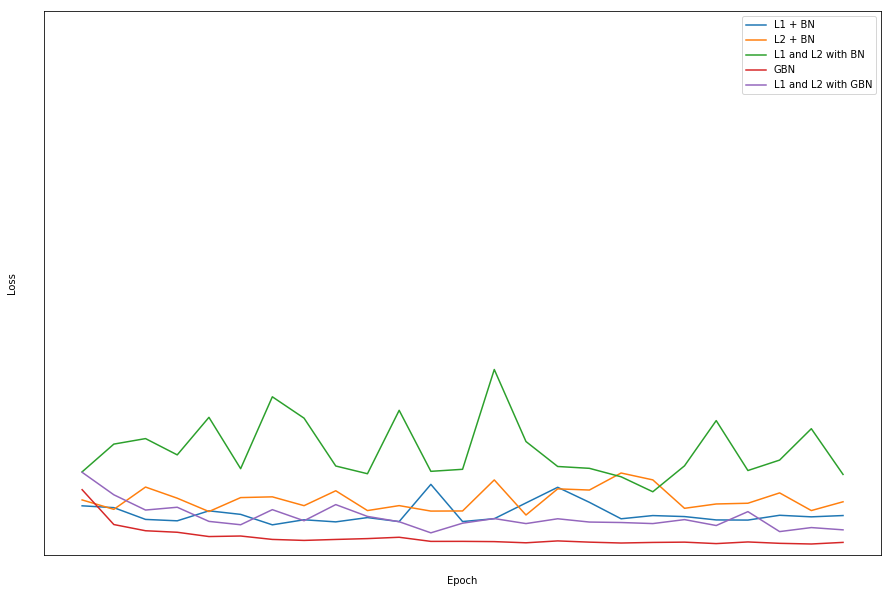

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
names = {1: 'L1 + BN', 2: 'L2 + BN', 3: 'L1 and L2 with BN', 4: 'GBN', 5: 'L1 and L2 with GBN'}

legends = []

for x in total_test_losses:
  ax.plot(total_test_losses[x])
  ax.set_ylim([0,1])
  ax.tick_params(axis='x', colors='white')
  ax.tick_params(axis='y', colors='white')
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Loss')
  legends.append(names[x])

ax.legend(legends)

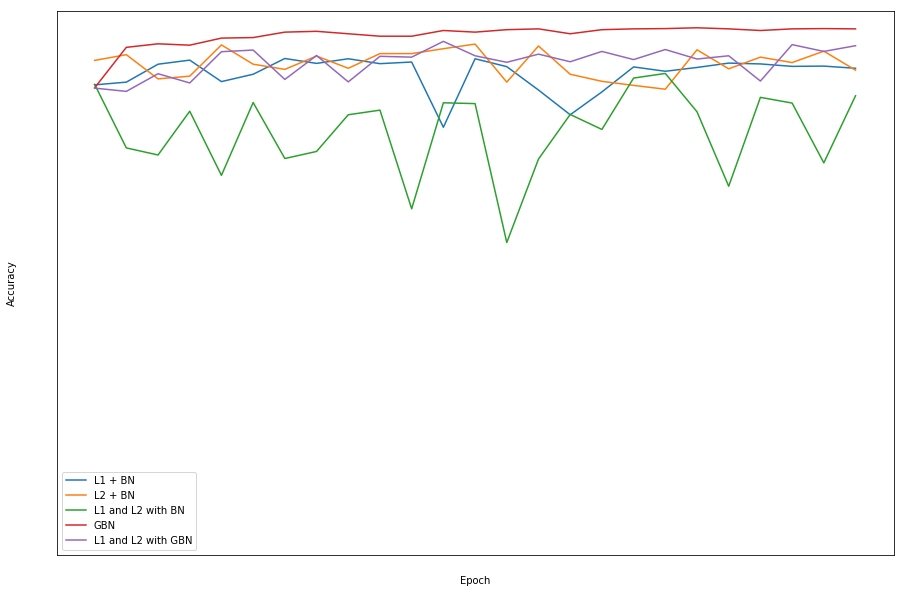

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
legends = []

for x in total_test_acc:
  ax.plot(total_test_acc[x])
  ax.set_ylim([80,100])
  ax.tick_params(axis='x', colors='white')
  ax.tick_params(axis='y', colors='white')
  ax.set_ylabel('Accuracy')
  ax.set_xlabel('Epoch')
  legends.append(names[x])

ax.legend(legends)

In [13]:
def get_mis_classified(model):
  train_loader_iterator = train_loader.__iter__()
  fail_count = 0
  failed_samples = []
  while fail_count < 25:
    data, target = train_loader_iterator.next()
    data, target = data.to(device), target.to(device)
    output = model(data)

    pred = output.argmax(dim=1, keepdim=True)
    failed_index = ~pred.eq(target.view_as(pred)).squeeze()

    failed_data = data[failed_index]
    failed_target = target[failed_index]
    failed_prediction = pred[failed_index]
    
    batch_fail_count = failed_data.size(dim=0)
    fail_count += batch_fail_count

    for count in range(batch_fail_count):
      failed_sample = {
          'image': failed_data[count].view(28, 28).cpu().numpy(),
          'Actual': failed_target[count],
          'Predicted': failed_prediction[count].item()
      }

      failed_samples.append(failed_sample)

  return failed_samples

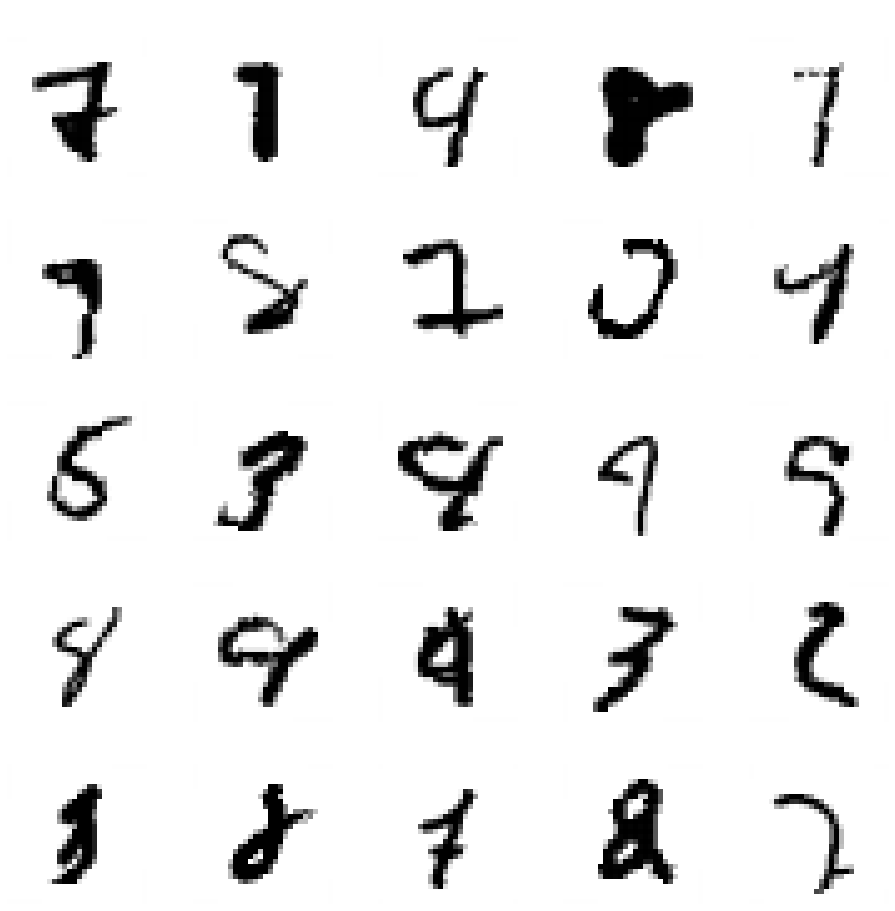

In [27]:
figure = plt.figure(figsize=(13, 13))
failed_samples = get_mis_classified(models[4])
for index in range(1, 26):
    ax = plt.subplot(5, 5, index)
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(failed_samples[index - 1]['image'], cmap='binary')
    title_obj = ax.set_title(f"Actual: {failed_samples[index - 1]['Actual']} \n Predicted: {failed_samples[index - 1]['Predicted']}")
    plt.setp(title_obj, color='w')